# 오토인코더를 사용하여 배경 제거
- 배경 제거: https://pixlr.com/kr/remove-background/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd /content/drive/MyDrive/데이터/텐서플로우

/content/drive/MyDrive/데이터/텐서플로우


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [5]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.
pfcn_small = np.load('pfcn_small.npz')
list(pfcn_small)

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [6]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

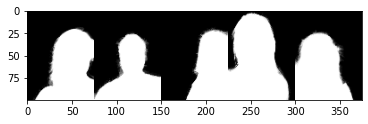

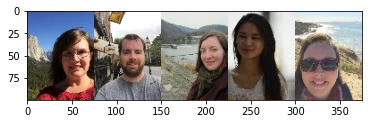

In [7]:
plt.imshow(np.hstack(train_mattes[:5]),cmap='gray')
plt.show()
    
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [8]:
print(np.shape(train_mattes))
print(np.shape(train_images))

print(np.shape(test_mattes))
print(np.shape(test_images))

(1700, 100, 75)
(1700, 100, 75, 3)
(300, 100, 75)
(300, 100, 75, 3)


In [9]:
# 스케일링 되어있는 자료인지 확인
print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

1.0 0.0
1.0 0.0


In [20]:
# 배열의 확장
train_mattes =np.expand_dims(train_mattes,axis=3) # 마지막 축에 차원 추가
test_mattes=np.expand_dims(test_mattes,axis=3)
train_mattes.shape, test_mattes.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

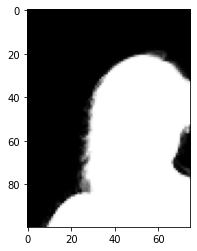

In [21]:
plt.imshow(train_mattes[0].reshape(100,75),cmap='gray')
plt.show()

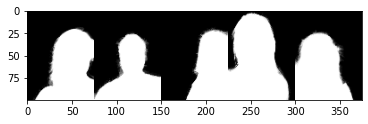

In [22]:
plt.imshow(train_mattes[:5].transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") # (5,100,75,1) => (100, 5, 75, 1) => (100, 375)
plt.show()

## AE 모델링

In [28]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
  inputs = Input((100, 75, 3))
  x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
  x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
  x = Flatten()(x)
  latent = Dense(10)(x)

  x = Dense((13 * 10 * 128))(latent)
  x = Reshape((13, 10, 128))(x)

  x = UpSampling2D(size = (2,2))(x) # 사이즈를 두배로 늘림
  x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
  
  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)

  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

  x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)


  model = Model(inputs, x)
  return model

In [29]:
model = ae_like()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 16640)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                166410    
_________________________________________________________________
dense_1 (Dense)              (None, 16640)             183040

In [30]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [31]:
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 34s 61ms/step - loss: 0.1396 - accuracy: 0.7512 - val_loss: 0.1256 - val_accuracy: 0.7619
Epoch 2/25
54/54 [==============================] - 3s 49ms/step - loss: 0.1249 - accuracy: 0.7654 - val_loss: 0.1156 - val_accuracy: 0.7736
Epoch 3/25
54/54 [==============================] - 3s 49ms/step - loss: 0.1085 - accuracy: 0.7860 - val_loss: 0.0955 - val_accuracy: 0.8020
Epoch 4/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0918 - accuracy: 0.8098 - val_loss: 0.0884 - val_accuracy: 0.8112
Epoch 5/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0826 - accuracy: 0.8220 - val_loss: 0.0833 - val_accuracy: 0.8178
Epoch 6/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0760 - accuracy: 0.8312 - val_loss: 0.0762 - val_accuracy: 0.8275
Epoch 7/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0683 - accuracy: 0.8412 - val_loss: 0.0715 - val_accuracy: 0.8342
Epoch 8/25
5

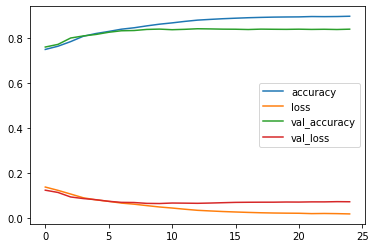

In [32]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "uppder left")
plt.show()

In [33]:
res = model.predict( test_images[0:1] )

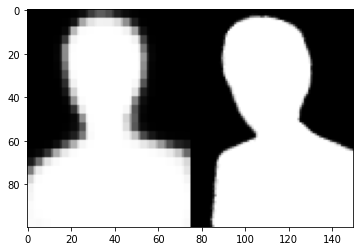

In [34]:
plt.imshow( np.concatenate([res[0], test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
# 딥러닝 결과, y자료
plt.show()

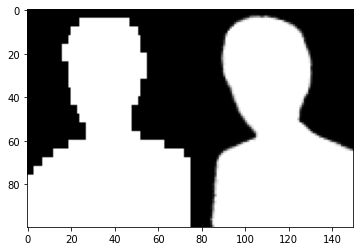

In [35]:
# res를 0.5기준으로 0,1의 값으로 이원화 시켜서 경계영역을 좀더 명확하게 함
plt.imshow( np.concatenate([(res[0] > 0.5).astype(np.float64), test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
plt.show()

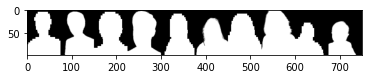

In [36]:
five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()

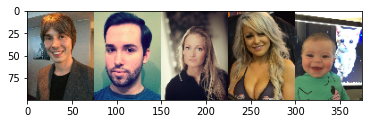

In [37]:
plt.imshow(test_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3))) 
plt.show()

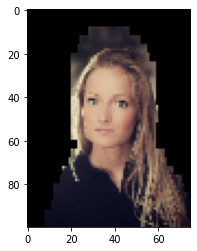

In [38]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지움

plt.imshow ( five[2].reshape((100, 75, 1)) * test_images[2]  ) # 흰색은 1, 검정색은 0 => 흰색은 영향을 미치지 않고 검정색은 영향을 미침.
plt.show()

##  U-net 모델링

In [39]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def unet_like():
  inputs = Input((100, 75, 3))
  # 인코더
  c1 = conv2d_block(inputs, 16) # 정규화
  p1 = MaxPool2D((2,2))(c1) # 두배로 줄임
  p1 = Dropout(0.1)(p1) # 드롭아웃

  c2 = conv2d_block(p1, 32)
  p2 = MaxPool2D((2,2))(c2)
  p2 = Dropout(0.1)(p2)

  c3 = conv2d_block(p2, 64)
  p3 = MaxPool2D((2,2))(c3)
  p3 = Dropout(0.1)(p3)

  c4 = conv2d_block(p3, 128)
  p4 = MaxPool2D((2,2))(c4)
  p4 = Dropout(0.1)(p4)

  c5 = conv2d_block(p4, 256)
  # 디코더
  u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(0.1)(u6)
  c6 = conv2d_block(u6, 128)

  u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(0.1)(u7)
  c7 = conv2d_block(u7, 64)

  u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(0.1)(u8)
  c8 = conv2d_block(u8, 32)

  u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(0.1)(u9)
  c9 = conv2d_block(u9, 16)

  outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

  model = Model(inputs, outputs)
  return model

In [40]:
# unet_like() 모델을 할당 받고 서머리를 출력
model = unet_like()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 75, 16)  448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [41]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [42]:
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 12s 150ms/step - loss: 0.1074 - accuracy: 0.7900 - val_loss: 0.1811 - val_accuracy: 0.6667
Epoch 2/25
54/54 [==============================] - 6s 118ms/step - loss: 0.0601 - accuracy: 0.8532 - val_loss: 0.1814 - val_accuracy: 0.6802
Epoch 3/25
54/54 [==============================] - 6s 118ms/step - loss: 0.0485 - accuracy: 0.8651 - val_loss: 0.2194 - val_accuracy: 0.6278
Epoch 4/25
54/54 [==============================] - 6s 118ms/step - loss: 0.0411 - accuracy: 0.8726 - val_loss: 0.1449 - val_accuracy: 0.7445
Epoch 5/25
54/54 [==============================] - 6s 118ms/step - loss: 0.0355 - accuracy: 0.8782 - val_loss: 0.1063 - val_accuracy: 0.7831
Epoch 6/25
54/54 [==============================] - 6s 118ms/step - loss: 0.0315 - accuracy: 0.8821 - val_loss: 0.0765 - val_accuracy: 0.8325
Epoch 7/25
54/54 [==============================] - 6s 118ms/step - loss: 0.0303 - accuracy: 0.8831 - val_loss: 0.0581 - val_accuracy: 0.8493
Epoch

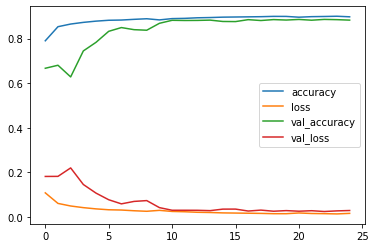

In [43]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "uppder left")
plt.show()

In [44]:
loss, acc = model.evaluate(test_images, test_mattes, verbose=1)
print(loss, acc)

10/10 [==============================] - 0s 42ms/step - loss: 0.0282 - accuracy: 0.8827
0.028197046369314194 0.8827057480812073


In [45]:
res = model.predict( test_images[2:3] )

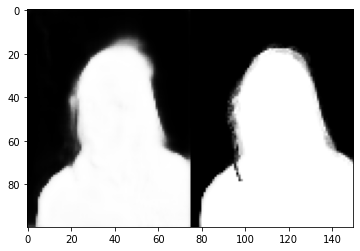

In [46]:
imgs = np.concatenate([res.reshape((100, 75, 1)), test_mattes[2]]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()

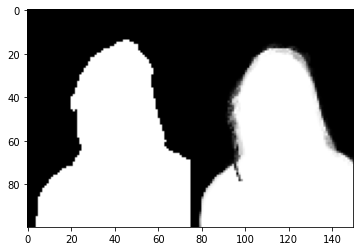

In [47]:
imgs = np.concatenate([(res > 0.5).astype(np.float64).reshape((100, 75, 1)), test_mattes[2] ]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()

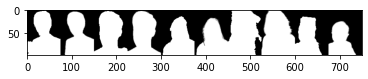

In [48]:
five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()

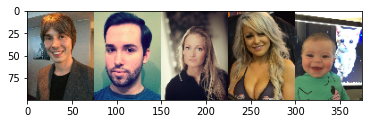

In [49]:
plt.imshow(test_images[:5].transpose((1,0, 2, 3)).reshape((100, -1, 3)))
plt.show()

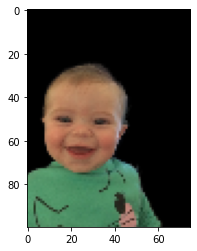

In [50]:
# 아래와 같이 나오는 것이 목적임(제공되는 배경제거 자료와 매칭한 자료)
plt.imshow(test_images[4] * test_mattes[4].reshape((100, 75 ,1)))
plt.show()

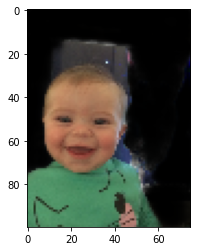

In [51]:
# 딥러닝 모델로 예측한 결과
plt.imshow(test_images[4] * model.predict(test_images[4:5]).reshape((100, 75 ,1)))
plt.show()

In [52]:
# 모델을 저장하는 코드를 작성하세요.
model.save("./배경제거.h5")